<h1 align="center" style="background-color:black;color:white;border-radius: 8px; padding:15px">T-Shirt Sleeve Classification using Convolutional Neural Networks</h1>

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">1. Import required libraries</h3>

In [1]:
import os
import random 
import gc
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms

import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Just some lil configurations

sns.set_style('darkgrid')

random_seed=42
torch.manual_seed(random_seed);

import warnings
warnings.filterwarnings('ignore')

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">2. Load Dataset</h3>

In [3]:
# Define the path and class names
base_dir = '/kaggle/input/classify-sleeves-with-tshirt-images'
class_dirs = ['half-sleeve-all-tshirt', 'long-sleeve-tshirts', 'sleeveless-all-tshirt']
class_names = ['Half Sleeve T-Shirt', 'Long Sleeve T-Shirt', 'Sleeveless T-Shirt']

In [4]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((100, 100)),        # Resize images to 100x100
    transforms.RandomRotation(30),        # Apply random rotation of 30 degrees
    transforms.RandomHorizontalFlip(),    # Apply random horizontal flip
    transforms.ToTensor(),                # Convert the image to a PyTorch Tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

In [5]:
dataset = datasets.ImageFolder(root=base_dir, transform=transform)

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">3. Visualize Dataset</h3>

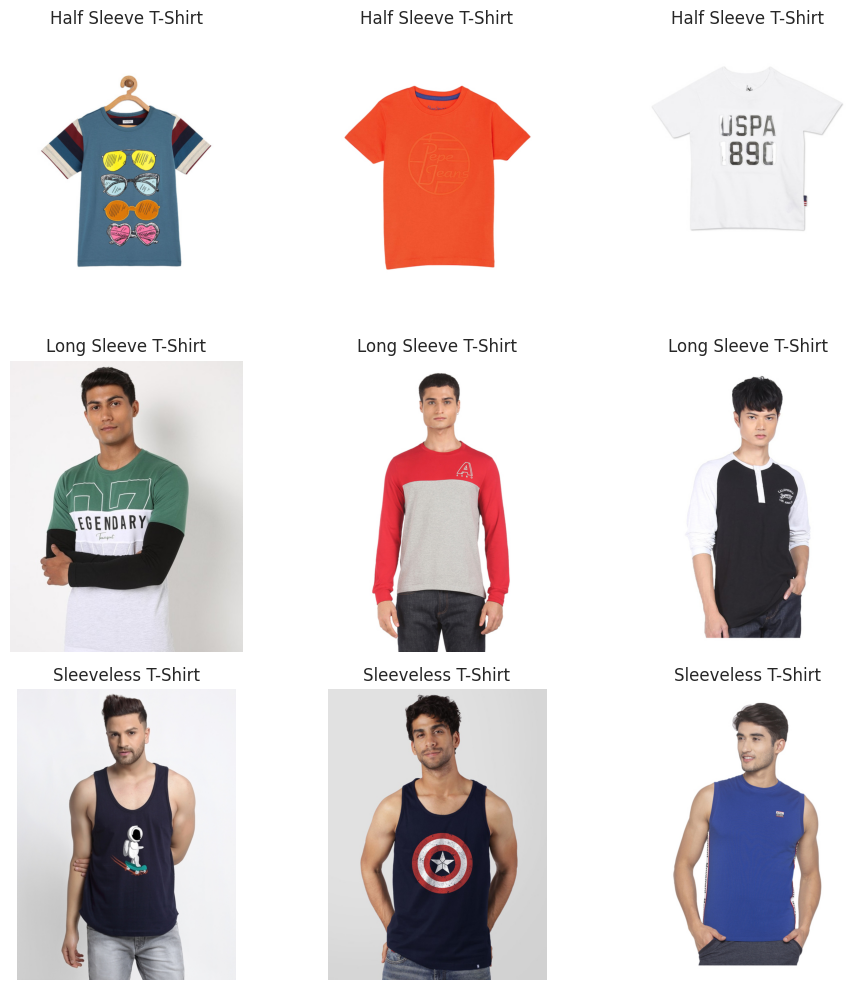

In [6]:
# Collect 3 random images from each class
images = []
labels = []
for class_dir, class_name in zip(class_dirs, class_names):
    img_files = random.sample(os.listdir(os.path.join(base_dir, class_dir)), 3)
    for img in img_files:
        images.append(Image.open(os.path.join(base_dir, class_dir, img)))
        labels.append(class_name)

# Plot images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i])
    ax.set_title(labels[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
def imshow_single(image, label):
    label_mapping = {0: 'Half Sleeve T-Shirt', 1: 'Long Sleeve T-Shirt', 2: 'Sleeveless T-Shirt'}
    
#     if isinstance(label, torch.Tensor):
#         label = label.item()
    
    print('Label:', label_mapping[label])
    
    plt.imshow(image.permute(1, 2, 0))  # Ensure correct dimension order for imshow
    plt.axis('off')                     # Disable the axis
    plt.show()

In [8]:
# imshow_single(*dataset[0])

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">4. Split Data into Train, Val and Test Set</h3>

In [9]:
# Define the sizes for the splits
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [10]:
# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [11]:
# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [12]:
# Example of checking the number of samples in each split
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

Training set: 4427 samples
Validation set: 948 samples
Test set: 950 samples


<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">5. Model Configuration</h3>

In [13]:
class ImageClassificationModelBase(nn.Module):
    """Base class for training, validation, and evaluation of image classification models."""

    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        val_acc = self.compute_accuracy(outputs, labels)
        val_precision = self.compute_precision(outputs, labels)
        val_recall = self.compute_recall(outputs, labels)
        val_f1 = self.compute_f1(outputs, labels)
        return {'val_loss': loss.detach(), 'val_acc': val_acc, 'val_precision': val_precision, 'val_recall': val_recall, 'val_f1': val_f1}
    
    def validation_epoch_end(self, outputs):
        epoch_metrics = {key: torch.stack([x[key] for x in outputs]).mean().item() for key in outputs[0]}
        return epoch_metrics
    
    def compute_accuracy(self, outputs, labels):
        _, predictions = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def compute_precision(self, outputs, labels):
        _, predictions = torch.max(outputs, dim=1)
        return torch.tensor(precision_score(labels.cpu(), predictions.cpu(), average='weighted'))

    def compute_recall(self, outputs, labels):
        _, predictions = torch.max(outputs, dim=1)
        return torch.tensor(recall_score(labels.cpu(), predictions.cpu(), average='weighted'))

    def compute_f1(self, outputs, labels):
        _, predictions = torch.max(outputs, dim=1)
        return torch.tensor(f1_score(labels.cpu(), predictions.cpu(), average='weighted'))

    def epoch_end(self, epoch, metrics):
        print(f"Epoch [{epoch}], train_loss: {metrics['train_loss']:.4f}, val_loss: {metrics['val_loss']:.4f}, "
              f"val_acc: {metrics['val_acc']:.4f}, val_precision: {metrics['val_precision']:.4f}, "
              f"val_recall: {metrics['val_recall']:.4f}, val_f1: {metrics['val_f1']:.4f}")

In [14]:
class SleeveClassificationCNN(ImageClassificationModelBase):
    """Convolutional Neural Network model for sleeve classification."""
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 64 x 50 x 50
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 32 x 25 x 25
            
            nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 16 x 12 x 12
            
            nn.Flatten(),
            nn.Linear(16 * 12 * 12, 512), nn.ReLU(),
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, 3)  # 3 output classes
        )
    
    def forward(self, xb):
        return self.network(xb)

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">6. Define Helper Functions for Visualizing metrics</h3>

In [15]:
def plot_loss(history):
    """Plot the training and validation loss."""
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, '-o', label='Train Loss')
    plt.plot(val_losses, '-o', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [16]:
def plot_val_metrics(history):
    """Plot validation accuracy, precision, recall, and F1 score over epochs on a single plot."""
    
    metrics = ['val_acc', 'val_precision', 'val_recall', 'val_f1']  # List of metrics to plot
    plt.figure(figsize=(10, 6))

    for metric_name in metrics:
        # Extract validation metrics
        val_metrics = [x[metric_name] for x in history if metric_name in x]

        # Plot validation metrics
        plt.plot(val_metrics, '-o', label=f'Validation {metric_name.capitalize()}')

    # Add title, labels, and legend
    plt.title('Validation Metrics over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.show()

In [17]:
def plot_confusion_matrix(model, data_loader, device):
    """Plot the confusion matrix for a given model and dataloader."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            images, labels = batch
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    label_mapping = {0: 'Half Sleeve', 1: 'Long Sleeve', 2: 'Sleeveless'}
    class_names = [label_mapping[i] for i in range(len(label_mapping))]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [18]:
@torch.no_grad()
def evaluate_test_set(model, test_loader):
    """Evaluate the model on the test set and compute metrics like accuracy, precision, recall, and f1 score."""
    model.eval()
    all_preds = []
    all_labels = []
    
    for batch in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = batch
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_acc = accuracy_score(all_labels, all_preds)
    test_precision = precision_score(all_labels, all_preds, average='weighted')
    test_recall = recall_score(all_labels, all_preds, average='weighted')
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return {
        'test_acc': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }

In [19]:
def plot_test_metrics(test_metrics):
    """Plot test accuracy, precision, recall, and F1 score in a bar chart."""
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [test_metrics['test_acc'], test_metrics['test_precision'], test_metrics['test_recall'], test_metrics['test_f1']]
    
    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 'lightpink'])
    plt.ylim([0, 1])  # Ensure that the y-axis limits are between 0 and 1
    plt.title('Test Metrics')
    plt.ylabel('Score')
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=12)
    plt.show()

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">7. Model Training</h3>

In [20]:
def to_device(data, device):
    """Move tensors to the specified device."""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [21]:
class DeviceDataLoader:
    """Dataloader that moves batches to a specified device."""
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)
    
    def __len__(self):
        return len(self.dl)

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluate the model on the validation set."""
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader, desc="Evaluating")]
    return model.validation_epoch_end(outputs)

In [23]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [24]:
# Instantiate model and prepare data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = to_device(SleeveClassificationCNN(), device)

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

In [25]:
# Training parameters
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [26]:
# Train the model
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Evaluating: 100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


Epoch [0], train_loss: 1.0861, val_loss: 1.0773, val_acc: 0.4356, val_precision: 0.1908, val_recall: 0.4356, val_f1: 0.2651


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch [1], train_loss: 1.0730, val_loss: 1.0695, val_acc: 0.4356, val_precision: 0.1908, val_recall: 0.4356, val_f1: 0.2651


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch [2], train_loss: 1.0213, val_loss: 0.9777, val_acc: 0.5248, val_precision: 0.4696, val_recall: 0.5248, val_f1: 0.4290


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch [3], train_loss: 0.8921, val_loss: 0.8114, val_acc: 0.6507, val_precision: 0.6541, val_recall: 0.6507, val_f1: 0.6432


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch [4], train_loss: 0.7487, val_loss: 0.6930, val_acc: 0.7124, val_precision: 0.7185, val_recall: 0.7124, val_f1: 0.7099


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch [5], train_loss: 0.5925, val_loss: 0.5309, val_acc: 0.7910, val_precision: 0.7993, val_recall: 0.7910, val_f1: 0.7925


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch [6], train_loss: 0.4653, val_loss: 0.4129, val_acc: 0.8474, val_precision: 0.8506, val_recall: 0.8474, val_f1: 0.8477


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch [7], train_loss: 0.3846, val_loss: 0.4412, val_acc: 0.8368, val_precision: 0.8445, val_recall: 0.8368, val_f1: 0.8374


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch [8], train_loss: 0.3563, val_loss: 0.3732, val_acc: 0.8806, val_precision: 0.8832, val_recall: 0.8806, val_f1: 0.8800


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch [9], train_loss: 0.2977, val_loss: 0.3497, val_acc: 0.8830, val_precision: 0.8877, val_recall: 0.8830, val_f1: 0.8833


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch [10], train_loss: 0.2931, val_loss: 0.3286, val_acc: 0.8909, val_precision: 0.8970, val_recall: 0.8909, val_f1: 0.8906


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch [11], train_loss: 0.2606, val_loss: 0.3305, val_acc: 0.8802, val_precision: 0.8825, val_recall: 0.8802, val_f1: 0.8799


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch [12], train_loss: 0.2540, val_loss: 0.3074, val_acc: 0.8972, val_precision: 0.8994, val_recall: 0.8972, val_f1: 0.8967


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch [13], train_loss: 0.2264, val_loss: 0.3287, val_acc: 0.8957, val_precision: 0.8986, val_recall: 0.8957, val_f1: 0.8953


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch [14], train_loss: 0.2344, val_loss: 0.2705, val_acc: 0.9078, val_precision: 0.9136, val_recall: 0.9078, val_f1: 0.9080


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch [15], train_loss: 0.2102, val_loss: 0.2847, val_acc: 0.9069, val_precision: 0.9099, val_recall: 0.9069, val_f1: 0.9068


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch [16], train_loss: 0.1882, val_loss: 0.2729, val_acc: 0.9137, val_precision: 0.9174, val_recall: 0.9137, val_f1: 0.9129


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch [17], train_loss: 0.1918, val_loss: 0.3140, val_acc: 0.9026, val_precision: 0.9063, val_recall: 0.9026, val_f1: 0.9015


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch [18], train_loss: 0.1717, val_loss: 0.2758, val_acc: 0.9074, val_precision: 0.9103, val_recall: 0.9074, val_f1: 0.9059


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]

Epoch [19], train_loss: 0.1842, val_loss: 0.2943, val_acc: 0.8961, val_precision: 0.8994, val_recall: 0.8961, val_f1: 0.8954


<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">8. Model Evaluation of Train and Validation Set</h3>

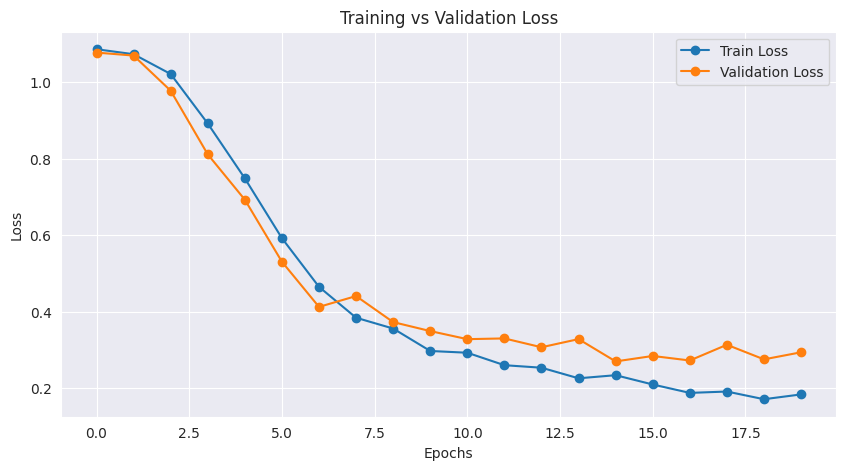

In [27]:
# Plot losses
plot_loss(history)

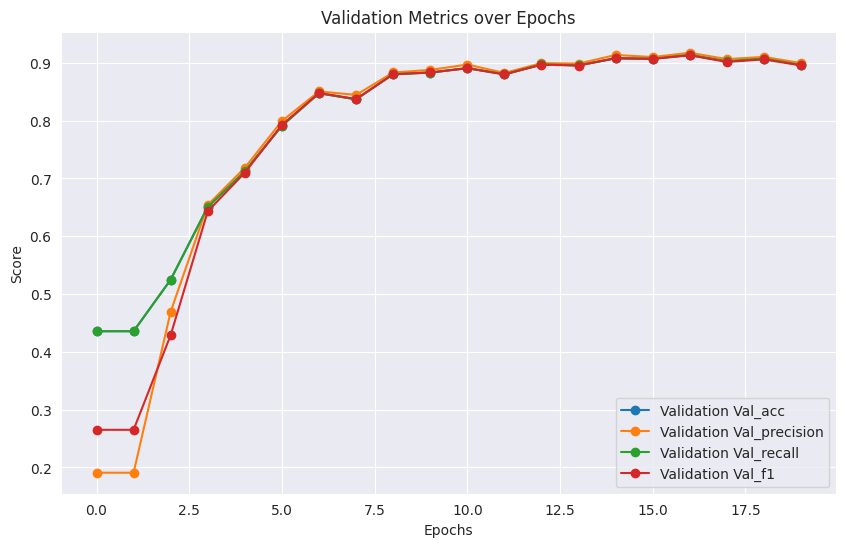

In [28]:
# Plot other metrics like accuracy, precision, recall, f1 score
plot_val_metrics(history)

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">9. Model Evaluation on Test Set</h3>

In [29]:
# Evaluate on the test set
test_metrics = evaluate_test_set(model, test_dl)

Evaluating on Test Set: 100%|██████████| 8/8 [00:13<00:00,  1.75s/it]


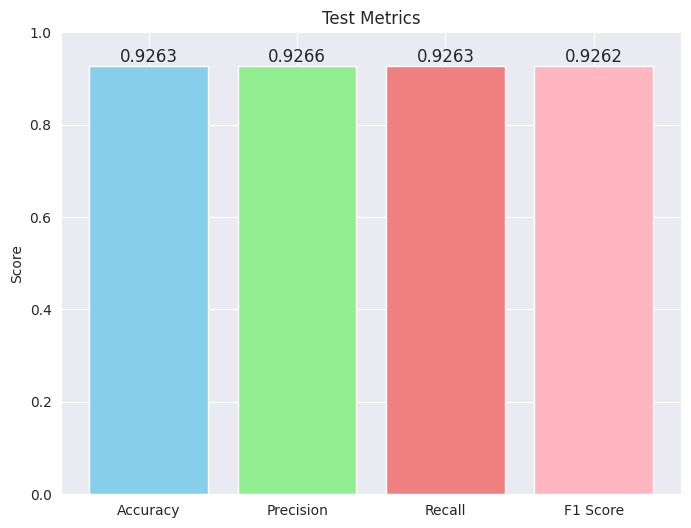

In [30]:
# Plot the test metrics
plot_test_metrics(test_metrics)

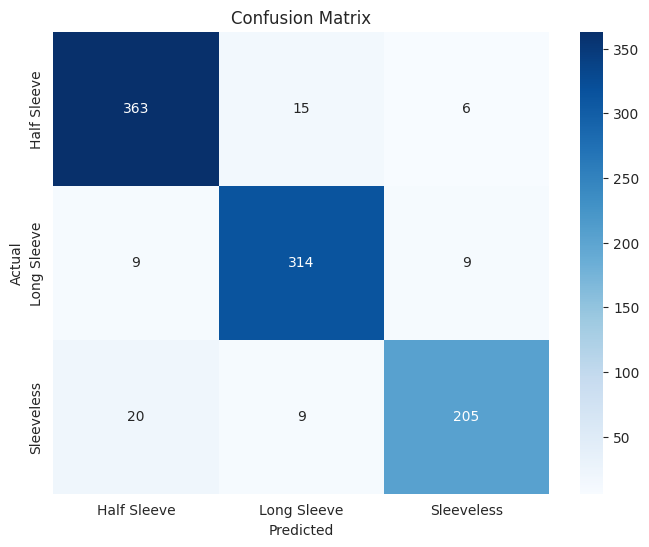

In [31]:
# Plot confusion matrix on test set
plot_confusion_matrix(model, test_dl, device)

Hmmm...

The model does have a hard time differentiating between half sleeve and sleeveless cloths. Not surprising though. What I will try to do next is use some regularization techniques and maybe a pre-trained model. 

See you in the next one 🙂